In [10]:
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.linalg as la
from sklearn.svm import SVC
# from JDIP import JDIP
# from MSJDIP import MSJDIP
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale,LabelEncoder
from os import path as osp
import autograd.numpy as anp
import autograd.numpy.linalg as alina
import pymanopt as pm
import pymanopt.manifolds as manifolds
import pymanopt.optimizers as optimizers
from sklearn.metrics import pairwise_distances
import autograd.numpy as anp
import autograd.numpy.linalg as alina
import numpy as np
import numpy.linalg as nlina
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.preprocessing import scale
import sys

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import datasets
from sklearn.manifold import TSNE

In [12]:

def roadDataMSbyCSV(root,scs, tg, Cs_end, Cu_start):
    Xs,Ys,l=[],[],[]
    li=0
    for sc in scs:  
        print('source {} is {}'.format(li,sc))
        source = np.array(pd.read_csv(osp.join(root,sc), header=None))
        source = source[source[:, -1] < Cs_end, :]  # 返回bool值作为行索引,选出符合数据
        Xsi = source[:, :-1]
        Ysi = source[:, -1].astype(int)
        Xsi = Xsi / nlina.norm(Xsi, axis=1, keepdims=True)
        Xs.append(Xsi)
        Ys.append(Ysi)
        l=np.hstack((np.array(l),np.full((source.shape[0],),li)))
        li+=1

    target = np.array(pd.read_csv(osp.join(root,tg), header=None))
    print('target {} is {}'.format(li,tg))
    

    C = np.size(np.unique(source[:, -1]))
    Cs = Cs_end
    Cu = C - Cu_start

    if Cs_end != Cu_start:
        target = np.vstack((target[target[:, -1] < Cs_end, :], target[target[:, -1] >= Cu_start, :]))
    Xt = target[:, :-1]
    Yt = target[:, -1].astype(int)
    Xt = Xt / nlina.norm(Xt, axis=1, keepdims=True)
    
    l=np.hstack((np.array(l),np.full((Xt.shape[0],),li)))

    return Xs, Ys, Xt, Yt,l,Cs, Cu

def cla_Svc(Xs, Xt, Ys):
    # 2.SVM分类模型
    model_cla = LinearSVC(dual=False)  # dual决定无法收敛时取消默认1000的迭代次数
    model_cla.fit(Xs, Ys)
    conf_matrix = model_cla.decision_function(Xt)
    conf_label = conf_matrix.argmax(axis=1)  # 每个样本最大置信度的索引,即类
    conf_vec = np.max(conf_matrix, axis=1)  # 每个样本最大置信度

    return conf_label, conf_vec

def compute_acc(Y, Y_pseudo, Cs):
    acc_os_all = 0
    acc_os_k = 0
    os = 0
    os_1 = 0 
    # print(Y)
    # print(Y_pseudo)
    # 计算已知类的分类准确率
    for c in range(Cs):
        os_1 = np.sum(Y_pseudo[Y == c] == Y[Y == c]) /Y[Y == c].shape
        acc_os_k += os_1
    acc_os_k = acc_os_k/Cs
    print(acc_os_k)
    # 计算未知类的分类准确率
    for c in range(Cs):
        os = np.sum(Y_pseudo[Y == c] == Y[Y == c]) /Y[Y == c].shape
        acc_os_all += os 
    os_unk = np.sum(Y_pseudo[Y >= Cs ] == Cs)/Y[Y >= Cs ].shape
    acc_os_all += os_unk
    acc_os_all = acc_os_all/(Cs+1)
    HOS=2*(acc_os_k*os_unk)/(acc_os_k+os_unk)
    return acc_os_all,os_unk,acc_os_k,HOS

def pseudo_fuc_ms(Xs, ys, Xt, Yt,Cs,Cu,conf=0):
    # 1.加载数据
    Xs=np.vstack(Xs)
    ys=np.hstack(ys)

    Xs = scale(Xs, with_std=False)
    Xt = scale(Xt, with_std=False)


    # 2.设置分类模型,标注已知类伪标签
    Xt_label, Xt_labelConf = cla_Svc(Xs, Xt, ys)

    # conf = -0.25  # 根据SVM定义,置信度大于0才属于已知类
    Xtk = Xt[Xt_labelConf >= conf]
    Ytk = Yt[Xt_labelConf >= conf]
    Ytk_pseudo = Xt_label[Xt_labelConf >= conf]
    Xtu = Xt[Xt_labelConf < conf]
    Ytu = Yt[Xt_labelConf < conf]
    Ytu_pseudo = Xt_label[Xt_labelConf < conf]
    Ytu_pseudo[:] = Cs
    

    # 5.目标域数据整合
    Xt_new = np.vstack((Xtk, Xtu))
    Yt_new = np.hstack((Ytk, Ytu))
    Yt_pseudo = np.hstack((Ytk_pseudo, Ytu_pseudo))
    

    
    acc,acc_unknown,acc_known,HOS=compute_acc(Yt_new,Yt_pseudo,Cs)
    # acc_known=compute_acc_known(Yt_new[Yt_new < Cs],Yt_pseudo[Yt_new < Cs], Cs)
    # one_unknown=compute_one_unknown(Yt_new[Yt_new >= Cs], Yt_pseudo[Yt_new >= Cs], Cs)
    print('all acc',acc)
    print("pseudo Xtu:", acc_unknown)
    print("pseudo Xtk:", acc_known)
    print('HOS:',HOS)

    return Xt_new,Yt_new,Yt_pseudo

def compute_acc(Y, Y_pseudo, Cs):
    acc_os_all = 0
    acc_os_k = 0
    os = 0
    os_1 = 0 
    # print(Y)
    # print(Y_pseudo)
    # 计算已知类的分类准确率
    for c in range(Cs):
        os_1 = np.sum(Y_pseudo[Y == c] == Y[Y == c]) /Y[Y == c].shape
        acc_os_k += os_1
    acc_os_k = acc_os_k/Cs
    print(acc_os_k)
    # 计算未知类的分类准确率
    for c in range(Cs):
        os = np.sum(Y_pseudo[Y == c] == Y[Y == c]) /Y[Y == c].shape
        acc_os_all += os 
    os_unk = np.sum(Y_pseudo[Y >= Cs ] == Cs)/Y[Y >= Cs ].shape
    acc_os_all += os_unk
    acc_os_all = acc_os_all/(Cs+1)
    HOS=2*(acc_os_k*os_unk)/(acc_os_k+os_unk)
    return acc_os_all,os_unk,acc_os_k,HOS

In [31]:
scs=['Clipart_Clipart.csv','Product_Product.csv','RealWorld_RealWorld.csv']
tg='Product_Art.csv'
domain_num=3
# root=osp.join('Office-31_Alex','Data_office31')
root='Office-Home_resnet50'
dataSet='OfficeHome'
# scs=['dslr.csv','webcam.csv']
# tg='amazon.csv'
# domain_num=3
# # root=osp.join('Office-31_Alex','Data_office31')
# root='resnet50Data'
# dataSet='Office31'

Cs_end,Cu_start=25,26
eta=0.002
gamma_tk=0.2
gamma_tu=0.7
# gamma_s=0.4
conf=0
u_conf=0

In [32]:
Xs,ys,Xt,yt,l,Cs,Cu=roadDataMSbyCSV(root,scs,tg,Cs_end,Cu_start)


source 0 is Clipart_Clipart.csv
source 1 is Product_Product.csv
source 2 is RealWorld_RealWorld.csv
target 3 is Product_Art.csv


In [33]:
Xt_new,Yt_new,Yt_pseudo=pseudo_fuc_ms(Xs,ys,Xt,yt,Cs,Cu,conf=conf)

[0.5299143]
all acc [0.54147561]
pseudo Xtu: [0.83050847]
pseudo Xtk: [0.5299143]
HOS: [0.64700227]


In [34]:
model = cluster.KMeans(n_clusters = len(np.unique(Yt_pseudo)), max_iter = 1000)
model.fit(Xt)
predicted = model.predict(Xt)
print('kmeans预测值',predicted)
# plt.scatter(x1_axis, x2_axis, c=predicted)#marker='s', s=100, cmap=plt.cm.Paired)
# plt.title("KMeans聚类分析")
# plt.show()

kmeans预测值 [19 25  6 ... 18  4  3]


In [35]:
avg_pure_rate=0
for i in range(len(np.unique(Yt_pseudo))):
    index,count=np.unique(yt[predicted==i],return_counts=True)
    
    pure_rate=max(count)/sum(count)
    avg_pure_rate+=pure_rate
    print(count,pure_rate)
avg_pure_rate/=len(np.unique(Yt_pseudo))
print(avg_pure_rate)

[ 1  3  1  2 20  1  3  6 11  1  1  1  2  1 36  8] 0.3673469387755102
[ 1 16  6 38 11  1] 0.5205479452054794
[14 20 18 29  1  1  1  2  1] 0.3333333333333333
[ 1 21  2  2  5  3  1  2  1  1  4  1  1  2  1  1 61  7  1  5  3  2  1  1
  1  4  1  1  1  6  2  1  2  2  1] 0.40131578947368424
[20  3  1  2  1 28  9  7  6  1  2  4  2  1  2  4  3  2 10  1  3  8  4  3
  2  3] 0.21212121212121213
[ 5  5  7  4  5 14  1  1 11  1  2 11  3  4 25  2] 0.24752475247524752
[ 1 79  1  1] 0.9634146341463414
[ 2  4  1  1 16  8  5  5 13  1 20  7  3  1  1  1  1] 0.2222222222222222
[ 6  5  2  2  3  2  1  1  2  1  1  1  1  1  1  3  1  4  1  1  1  2  5  3
  1  1  2  6  8  1  1 18  4  4  1  1  3  3 15  1] 0.1487603305785124
[ 1  4  3  2  1  1 12  2  1  3  1  1  1  8  5  1  2  1  7  1  1  1  1  1
  1  4  1  1  1  2  5  3  1  3 10  1  1  1] 0.12371134020618557
[ 5  9  1 60  3  1  2  9  3  3  7] 0.5825242718446602
[ 1 29  4  1  1  9  4  1] 0.58
[56  1] 0.9824561403508771
[ 1  2  1  2  2 13  1 16  3  2  1  6 10  2  3  8 

In [20]:
compute_acc(yt,predicted,Cs)

[0.01634894]


(array([0.02346887]),
 array([0.09466812]),
 array([0.01634894]),
 array([0.02788263]))

In [18]:
len(np.unique(yt))

65

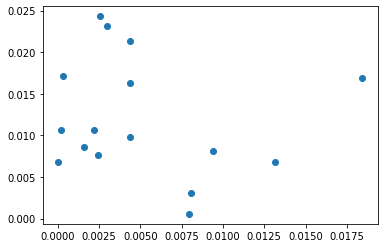

In [19]:
from numpy import where
from sklearn.datasets import make_classification
from matplotlib import pyplot
# 定义数据集
X, y = Xt,yt
# 为每个类的样本创建散点图
for class_value in range(len(np.unique(yt))):
# 获取此类的示例的行索引
    row_ix=where(y == class_value)
# 创建这些样本的散布
pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

c:\Users\10913\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\10913\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
c:\Users\10913\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\10913\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\10913\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarni

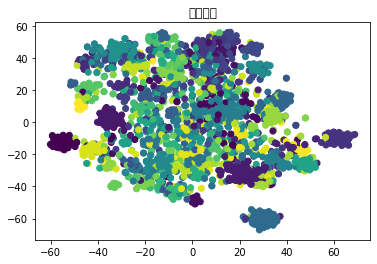

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import datasets
from sklearn.manifold import TSNE
data_TSNE = TSNE(n_components=2).fit_transform(Xt)
x1_axis = data_TSNE[:,0]
x2_axis = data_TSNE[:,1]
real = yt
plt.scatter(x1_axis, x2_axis, c=real)
plt.title("真实分类")
plt.show()




kmeans预测值 [13  3 13 ... 22 14  9]


c:\Users\10913\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\10913\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\10913\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\10913\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26512 (\N{CJK UNIFIED IDEOGRAPH-6790}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


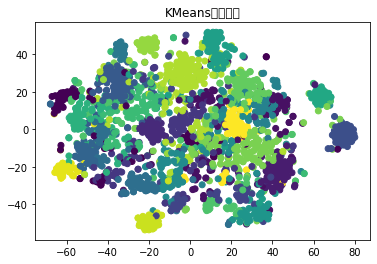

In [60]:
model = cluster.KMeans(n_clusters = len(np.unique(Yt_pseudo)), max_iter = 1000)
model.fit(Xt)
predicted = model.predict(Xt)
print('kmeans预测值',predicted)
plt.scatter(x1_axis, x2_axis, c=predicted)#marker='s', s=100, cmap=plt.cm.Paired)
plt.title("KMeans聚类分析")
plt.show()

In [58]:
model_DBSCAN=cluster.DBSCAN(eps=0.65,min_samples=5)
model_DBSCAN.fit(Xt)
model_DBSCAN.labels_
np.unique(model_DBSCAN.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [60]:
dp=[[i*j for i in range(1,5)] for j in range(1,5)]
dp

[[1, 2, 3, 4], [2, 4, 6, 8], [3, 6, 9, 12], [4, 8, 12, 16]]

In [61]:
dp[:][2]

[3, 6, 9, 12]

In [34]:
len(np.unique(Yt_pseudo))

26

In [61]:
n_clusters=len(np.unique(predicted))
for clu in range(n_clusters):
    print(yt[predicted==clu])
    

[48 52 60  8 48 62  8 52 14 52 52 20 52 52 52 19  8 52 52 52 33 62 33 52
 34 54 52 54  8 52 13 32 48 52 48 62 52 52 38 52 38 52  2 52 48  8 52 29
 20 44  8 60 12  8 52 52 48 22 48 21 23 34  2 23 48 32 34 29 48  7 62  3
 35 52 52 48 62 34 52 52 33 52 48  8  8 52 18 11 34  7  8  8]
[25 24 37 21 59  9 36 64 61 36 43 40 40 36 25 25 36 57 40 24 63 50 25 57
 57 25 25 15 25 25 61 36 57 41 61 50 40 25 57 25 50 25  5 25 35  9 24 57
 41 36  6 57 57 57 24 35 25 57 24 36 57 57 41 57 40  5 41 25 36 25 19 25
 25 25 36 40 34 57 25 26 36 25 25 57 25 25 57 40 41 25 25 40 50 59 36 40
 57 40 24 61 64 25 40 37 36 61 57 57 40 49 24 40 25 40 24 25]
[ 5  5 55  5 55  5  5 55 55 63  5  5  5 28  5  5  5 55 55  5  5 55  5  5
  5  5  5  5  2  5  5  5 55  5 48 61  5 55 63 55 55 55 55 37  5  5  5 46
  5  9  5 55 61  5  5  5 55  2 55  5  5  5  5  5  5  5  5  5  5 55 55  5
  5  5  5  5 61  5  5  5  5  5  5 55  5  5  5  5 55  5 55 61  5  5  5  5
  5  5  5  5  5  5  5 55  5  5 61  9  5]
[ 4  4  4  4  0  4  4  4  4  4  

In [37]:
Yt_pseudo[predicted==1]

array([12, 25, 25], dtype=int64)

In [22]:
len(predicted)

2427

In [23]:
compute_acc(yt,predicted,Cs)

[0.03684629]


(array([0.03568783]),
 array([0.00672646]),
 array([0.03684629]),
 array([0.01137615]))

In [59]:
L1,L2=ListNum1,ListNum2
while L1 is not None:
    print(L1.val,end=' ')
    L1=L1.next
print()
while L2 is not None:
    print(L2.val,end=' ')
    L2=L2.next

0 8 6 5 6 8 3 5 7 
6 7 8 0 8 5 8 9 7 

In [60]:
Sul=addTwoNumbers(ListNum1,ListNum2)

In [61]:
Sul.next.val

7

In [62]:
l1,l2=ListNum1,ListNum2

In [65]:
listl1=l1
listl2=l2
sum=ListNode(0,None)
sum_h=sum
len1,len2=0,0
while listl1 is not None:
    listl1=listl1.next
    len1+=1
while listl2 is not None:
    listl2=listl2.next
    len2+=1
diff = len1 - len2
maxlen=max(len1,len2)
listl1=l1
listl2=l2
# print(len1,len2,diff)
add_temp=0
print(maxlen-abs(diff))
for i in range(maxlen-abs(diff)): 
    tempNode=ListNode((listl1.val+listl2.val+add_temp)%10,None)
    print(listl1.val,listl2.val,(listl1.val+listl2.val+add_temp)%10)
    add_temp=(listl1.val+listl2.val+add_temp)//10
    # print(listl1.val,listl2.val)
    sum_h.next=tempNode
    sum_h=sum_h.next
    listl1=listl1.next
    listl2=listl2.next
if diff>0:
    for i in range(diff):
        tempNode=ListNode((listl1.val+add_temp)%10,None)
        add_temp=(listl1.val+add_temp)//10
        sum_h.next=tempNode
        sum_h=sum_h.next
        listl1=listl1.next
else :
    for i in range(-diff):
        tempNode=ListNode((listl2.val+add_temp)%10,None)
        add_temp=(listl2.val+add_temp)//10
        sum_h.next=tempNode
        sum_h=sum_h.next
        listl2=listl2.next
if add_temp!=0:
    tempNode=ListNode(add_temp,None)
    sum_h.next=tempNode
    sum_h=sum_h.next
    print(add_temp)
sum=sum.next

9
0 6 6
8 7 5
6 8 5
5 0 6
6 8 4
8 5 4
3 8 2
5 9 5
7 7 5
1


In [64]:
L3=sum
while L3 is not None:
    print(L3.val,end=' ')
    L3=L3.next

6 5 5 6 4 4 2 5 5 1 

In [119]:
x=[3,2,4,1]

In [96]:
import operator
max_index, max_number = max(enumerate(x[:len(x)]), key=operator.itemgetter(1))
print(x[:len(x)])

[3, 2, 4, 1]


In [126]:
x=[3,2,4,1]
def pancakeSort(arr):
    length=len(arr)
    if length==1:
        return []
    elif length==2:
        if arr[1]>arr[2]:
            return []
        else: 
            return [2]
    
    res=[]
    for i in range(length-1):
        maxIndex,maxNum=max(enumerate(arr[:(length-i)]), key=operator.itemgetter(1))
        tempArr=arr[:(maxIndex+1)]
        tempArr.reverse()
        arr[:(maxIndex+1)]=tempArr
        tempArr=arr[:(length-i)]
        tempArr.reverse()
        arr[:(length-i)]=tempArr
        print(arr)
        res.append(maxIndex+1)
        res.append(length-i)
    return res

res=pancakeSort(x)
print(res)

[1, 3, 2, 4]
[2, 1, 3, 4]
[1, 2, 3, 4]
[3, 4, 2, 3, 1, 2]


In [21]:
class Solution:
    def maximalRectangle(self, matrix) -> int:
        n,m,ans=len(matrix),len(matrix[0]),0
        psum=[[0]*(m) for i in range(n)]
        for i in range(0,n):
            for j in range(0,m):
                # print(matrix[i][j])
                if matrix[i][j]=='1':
                    if i>0:
                        psum[i][j]=psum[i-1][j]+1
                    else:
                        psum[i][j]=1
        print(psum)
        for i in range(0,n):
            cur=[0]+psum[i]+[0]
            print(cur)
            stack=[0]
            for j in range(1,m+2):
                while cur[j]<cur[stack[-1]]:
                    current_height=cur[stack.pop()]
                    curr_area=current_height*(j-1-stack[-1])
                    print(cur[j],current_height,curr_area)
                    ans=max(curr_area,ans)
                stack.append(j)
        
        return ans
S=Solution()
matrix = [["1","0","1","0","0"],["1","0","1","1","1"],["1","1","1","1","1"],["1","0","0","1","0"]]
S.maximalRectangle(matrix)

[[1, 0, 1, 0, 0], [2, 0, 2, 1, 1], [3, 1, 3, 2, 2], [4, 0, 0, 3, 0]]
[0, 1, 0, 1, 0, 0, 0]
0 1 1
0 1 1
[0, 2, 0, 2, 1, 1, 0]
0 2 2
1 2 2
0 1 1
0 1 3
[0, 3, 1, 3, 2, 2, 0]
1 3 3
2 3 3
0 2 2
0 2 6
0 1 5
[0, 4, 0, 0, 3, 0, 0]
0 4 4
0 3 3


6

In [4]:
def HOS(a,b):
    return 2*a*b/(a+b)
HOS(94.3,91.6)

92.93039268423884

In [66]:
class Solution:
    def maxEnvelopes(self, envelopes) -> int:
        envelopes=sorted(envelopes,key=lambda x:(x[0],x[1]))
        m=len(envelopes)
        dp=[[0]*m for _ in range(m)]
        for i in range(m):
            dp[i][i]=1#肯定能装进自己
        for i in range(m):
            print(dp)
            if i>0:
                dp[:][i][:i]
                dp[i][i]=max([d[i] for d in dp])#其他信封的最大值装进去 累加
            for j in range(i,m):
                if envelopes[j][0]>envelopes[i][0] and envelopes[j][1]>envelopes[i][1]:#可以装进去，累加
                    dp[i][j]=dp[i][i]+1
        print(dp)
        return max(max(d) for d in dp)
S=Solution()
S.maxEnvelopes([[5,4],[6,4],[6,7],[2,3]])

[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
[[1, 2, 2, 2], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
[[1, 2, 2, 2], [0, 2, 0, 3], [0, 0, 1, 0], [0, 0, 0, 1]]
[[1, 2, 2, 2], [0, 2, 0, 3], [0, 0, 2, 0], [0, 0, 0, 1]]
[[1, 2, 2, 2], [0, 2, 0, 3], [0, 0, 2, 0], [0, 0, 0, 3]]


3

In [56]:
m=4
dp=[[0]*m for _ in range(m)]
for i in range(m):
    dp[i][i]=1#肯定能装进自己
dp

[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

In [58]:
dp[:][2]

[0, 0, 1, 0]

In [ ]:
max([d[i] for d in dp])